<p style="font-family: Arial; font-size:2.75em;color:purple; font-style:bold"><br>
Clustering with scikit-learn
<br><br></p>

In this notebook, we will learn how to perform k-means clustering using scikit-learn in Python. 

We will use cluster analysis to generate a big picture model of the weather at a local station using a minute-granularity data. In this dataset, we have in the order of one millions records. How do we create 12 clusters our of them?

**NOTE:** The dataset we will use is in a large CSV file called *minute_weather.csv*. Please download it into the *weather* directory in your *Week-7-MachineLearning* folder. 

The download link is: https://drive.google.com/open?id=0B8iiZ7pSaSFZb3ItQ1l4LWRMTjg 

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>
Importing the Necessary Libraries
<br><br></p>

In [16]:
# Below can be used to change the width of the Jupyter notebook. I did this so that the full dataset with all variables can be seen without needing to use the scrollbar

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from itertools import cycle, islice
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

%matplotlib inline

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>
Creating a Pandas DataFrame from a CSV file<br><br></p>


In [2]:
data = pd.read_csv('./weather/minute_weather.csv')

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>
    Minute Weather Data Description</p>

<br>

The **minute weather dataset** comes from the same source as the daily weather dataset that we used in the decision tree based classifier notebook. The main difference between these two datasets is that the minute weather dataset contains raw sensor measurements captured at one-minute intervals. The daily weather dataset instead contained processed and well curated data. The data is in the file **minute_weather.csv**, which is a comma-separated file.

As with the daily weather data, this data comes from a weather station located in San Diego, California. The weather station is equipped with sensors that capture weather-related measurements such as air temperature, air pressure and relative humidity. Data was collected over a period of three years, from September 2011 to September 2014, to ensure that sufficient data for different seasons and weather conditions was captured.

Each row, or sample, in **minute_weather.csv** contains weather data captured for a one-minute interval and consists of the following variables:

* **rowID:** 	unique number for each row	(*Unit: NA*)
* **hpwren_timestamp:**	timestamp of measure	(*Unit: year-month-day hour:minute:second*)
* **air_pressure:** air pressure measured at the timestamp	(*Unit: hectopascals*)
* **air_temp:**	air temperature measure at the timestamp	(*Unit: degrees Fahrenheit*)
* **avg_wind_direction:**	wind direction averaged over the minute before the timestamp	(*Unit: degrees, with 0 means coming from the North, and increasing clockwise*)
* **avg_wind_speed:**	wind speed averaged over the minute before the timestamp	(*Unit: meters per second*)
* **max_wind_direction:**	highest wind direction in the minute before the timestamp	(*Unit: degrees, with 0 being North and increasing clockwise*)
* **max_wind_speed:**	highest wind speed in the minute before the timestamp	(*Unit: meters per second*)
* **min_wind_direction:**	smallest wind direction in the minute before the timestamp	(*Unit: degrees, with 0 being North and inceasing clockwise*)
* **min_wind_speed:**	smallest wind speed in the minute before the timestamp	(*Unit: meters per second*)
* **rain_accumulation:**	amount of accumulated rain measured at the timestamp	(*Unit: millimeters*)
* **rain_duration:**	length of time rain has fallen as measured at the timestamp	(*Unit: seconds*)
* **relative_humidity:**	relative humidity measured at the timestamp	(*Unit: percent*)

In [3]:
data.shape

(1587257, 13)

In [15]:
data.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8


<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>
Data Sampling<br><br?</p>

There are lots of rows, so let us sample down by taking every 10th row. Now we have every 10th minute data rather than every minute.<br>


In [34]:
# Below we index using a boolean mask array which is true for every sample where rowID divided by 10 = 0

sampled_df = data[(data['rowID'] % 10) == 0]

# By checking the shape, we can see we have a 10th of the amount of rows now.
sampled_df.shape

(158726, 13)

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>
Statistics
<br><br></p>


In [27]:
# .transpose() is used to move the columns in to rows and vice versa (and  move the data accordingly). 
# In this case, due to the long variable names, it shortens the width of the dataframe

sampled_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rowID,158726.0,793625.000000,458203.937509,0.00,396812.5,793625.00,1190437.50,1587250.00
air_pressure,158726.0,916.830161,3.051717,905.00,914.8,916.70,918.70,929.50
air_temp,158726.0,61.851589,11.833569,31.64,52.7,62.24,70.88,99.50
avg_wind_direction,158680.0,162.156100,95.278201,0.00,62.0,182.00,217.00,359.00
avg_wind_speed,158680.0,2.775215,2.057624,0.00,1.3,2.20,3.80,31.90
max_wind_direction,158680.0,163.462144,92.452139,0.00,68.0,187.00,223.00,359.00
max_wind_speed,158680.0,3.400558,2.418802,0.10,1.6,2.70,4.60,36.00
min_wind_direction,158680.0,166.774017,97.441109,0.00,76.0,180.00,212.00,359.00
min_wind_speed,158680.0,2.134664,1.742113,0.00,0.8,1.60,3.00,31.60
rain_accumulation,158725.0,0.000318,0.011236,0.00,0.0,0.00,0.00,3.12


Below we are checking how many minutes (samples) of data have no rain accumulation or rain duration. By checking the shape we can see that a significant amount of the data has no rain, e.g. the value is 0.

In [28]:
sampled_df[sampled_df['rain_accumulation'] == 0].shape

(157812, 13)

In [29]:
sampled_df[sampled_df['rain_duration'] == 0].shape

(157237, 13)

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>
Due to the lack of data for the rain variables, lets drop these columns
<br><br></p>


In [35]:
del sampled_df['rain_accumulation']
del sampled_df['rain_duration']

Below we also drop samples which have any variable as null values. First lets see where the null values are. As can be seen, no wind data was recorded for these samples. Perhaps due to sensor fault.

In [ ]:
sampled_df_nulls = sampled_df[sampled_df.isna().any(axis=1)]

In [45]:
sampled_df_nulls.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,relative_humidity
34790,34790,2011-10-04 10:25:48,915.7,51.08,NaN,NaN,NaN,NaN,NaN,NaN,91.0
36320,36320,2011-10-05 11:55:49,914.7,50.00,NaN,NaN,NaN,NaN,NaN,NaN,91.9
36330,36330,2011-10-05 12:05:49,914.4,50.18,NaN,NaN,NaN,NaN,NaN,NaN,92.0
79100,79100,2011-11-04 04:55:50,911.1,48.92,NaN,NaN,NaN,NaN,NaN,NaN,91.4
79250,79250,2011-11-04 07:25:50,910.6,48.02,NaN,NaN,NaN,NaN,NaN,NaN,91.8


In [46]:
rows_before = sampled_df.shape[0]
sampled_df = sampled_df.dropna()
rows_after = sampled_df.shape[0]

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>
How many rows did we drop ?
<br><br></p>


After deleting the null values for missing wind data, we see that only 46 datapoints were removed.

In [49]:
rows_before - rows_after

46

In [50]:
sampled_df.columns

Index(['rowID', 'hpwren_timestamp', 'air_pressure', 'air_temp',
       'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction',
       'max_wind_speed', 'min_wind_direction', 'min_wind_speed',
       'relative_humidity'],
      dtype='object')

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>
Select Features of Interest for Clustering
<br><br></p>


Below we select features that we want to use for our clustering. We drop the irrelevent rowID and other features including timestamp, min wind direction and min wind speed. We then store this in to a new dataframe named "select_df" by applying a mask of the features we want to keep.

In [52]:
features = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']

In [53]:
select_df = sampled_df[features]

In [54]:
select_df.columns

Index(['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed',
       'max_wind_direction', 'max_wind_speed', 'relative_humidity'],
      dtype='object')

In [56]:
select_df.head()

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity
0,912.3,64.76,97.0,1.2,106.0,1.6,60.5
10,912.3,62.24,144.0,1.2,167.0,1.8,38.5
20,912.2,63.32,100.0,2.0,122.0,2.5,58.3
30,912.2,62.60,91.0,2.0,103.0,2.4,57.9
40,912.2,64.04,81.0,2.6,88.0,2.9,57.4


<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>
Scale the Features using StandardScaler
<br><br></p>


To keep values of different columns comparable, we scale the values in these features. We can use sklearn's StandardScaler to accomplish this.
StandardScaler is an object, and if we pass in a dataframe to it, in this case its function `.fit_transform()`, it returns nicely scaled input data which we can use for our clustering operation.

Standardizing features is accomplished by removing the mean and scaling to unit variance. The standard score of a sample x is calculated as:

`z = (x - u) / s`

Returned dataframe X below is a numpy array containing scaled numbers for our initial data. This will later be used as an input for our k-Means modelling later on.

In [67]:
X = StandardScaler().fit_transform(select_df)
X

array([[-1.48456281,  0.24544455, -0.68385323, ..., -0.62153592,
        -0.74440309,  0.49233835],
       [-1.48456281,  0.03247142, -0.19055941, ...,  0.03826701,
        -0.66171726, -0.34710804],
       [-1.51733167,  0.12374562, -0.65236639, ..., -0.44847286,
        -0.37231683,  0.40839371],
       ...,
       [-0.30488381,  1.15818654,  1.90856325, ...,  2.0393087 ,
        -0.70306017,  0.01538018],
       [-0.30488381,  1.12776181,  2.06599745, ..., -1.67073075,
        -0.74440309, -0.04948614],
       [-0.30488381,  1.09733708, -1.63895404, ..., -1.55174989,
        -0.62037434, -0.05711747]])

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>
Use k-Means Clustering
<br><br></p>

Below we create a KMeans object and assign it to variable kmeans. We specify the number of clusters as 12. Using our kmeans object, we use the `.fit()` method and pass in our scaled input data X. This computes the K-means clustering.

Note that we are using seven features, stored in our features list, to perform clustering. 

In [68]:
kmeans = KMeans(n_clusters=12)
model = kmeans.fit(X)
print("model\n", model)

model
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)


<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>
What are the centers of 12 clusters we formed ?
<br><br></p>

We can view each of the cluster centers using the Kmeans `.cluster_centers_` attribute. Each center is a list of seven floating point numbers, which denotes where the cluster center stands in the seven dimensions of our feature space. 

We assign this to a variable named centers, which is an ndarray. For each 12 clusters, it has those seven values.

In [79]:
centers = model.cluster_centers_
centers

array([[-1.18016187, -0.87551988,  0.44665231,  1.97739659,  0.53863115,
         1.93893611,  0.91368307],
       [-0.69637283,  0.54281793,  0.17711043, -0.58387815,  0.3464243 ,
        -0.59726585, -0.11365151],
       [ 0.06100833, -0.7887917 , -1.19674129, -0.57094351, -1.04273463,
        -0.58547529,  0.8782675 ],
       [ 0.72970869,  0.43674027,  0.28549419, -0.53488532,  0.47332796,
        -0.54113087, -0.77183155],
       [-0.16402125,  0.86380436, -1.31100595, -0.58978308, -1.16671105,
        -0.60511908, -0.64091668],
       [ 1.36630997, -0.0810317 , -1.20729281, -0.04954634, -1.07617348,
        -0.02923106, -0.9777014 ],
       [ 0.25146003, -0.99458776,  0.65967163, -0.54720479,  0.85099169,
        -0.52992757,  1.158503  ],
       [-0.2111878 ,  0.6319451 ,  0.40854189,  0.73494266,  0.51667699,
         0.67289223, -0.1502902 ],
       [ 0.2339313 ,  0.31909585,  1.88794143, -0.65198177, -1.55164369,
        -0.57681439, -0.28251551],
       [ 0.13086607,  0.8436

<p style="font-family: Arial; font-size:2.75em;color:purple; font-style:bold"><br>
Plots
<br><br></p>

Now that we have the 12 cluster centers, lets go about visualizing it.

Let us first create some utility functions which will help us in plotting graphs:

In [96]:
# Function that takes our ndarray and creates a DataFrame (with headers) and a column for Cluster Number

def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')

	# Zip with a column called 'prediction' (index)
    # Note: Python enumerate() method loops over something, e.g. a list, and has an automatic counter.
	Z = [np.append(A, index) for index, A in enumerate(centers)]

	# Convert to pandas data frame for plotting
	P = pd.DataFrame(Z, columns=colNames)
    
    # .astype() is a Pandas method that casts a pandas object to a specified datatype, e.g. from float to int etc.
	P['prediction'] = P['prediction'].astype(int)
	return P

In [109]:
# Function that creates Parallel Plots (used for plotting)

def parallel_plot(data):
    # The islice() function works much the same way as slicing a list or tuple. You pass it an iterable (e.g. a list), a starting, and stopping point, and, just like slicing a list, 
    # the slice returned stops at the index just before the stopping point. You can optionally include a step value, as well. The biggest difference here is, of course, that 
    # islice() returns an iterator.
    # The cycle() function makes an iterator returning elements from the iterable and saving a copy of each. When the iterable is exhausted, it returns elements from the saved copy. 
    # Repeats indefinitely.
	my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
    
    # the pyplot .gca() method gets the current polar axes on the current figure. If the current axes doesn't exist, or isn't a polar one, 
    # the appropriate axes will be created and then returned.
	plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
    
    # the pandas.plotting parallel_coordinates() method takes in arguments (frame, column_name) among others. column_name becomes the key for each cluster, and is not used as a feature.
	parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

In [94]:
P = pd_centers(features, centers)
P

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,prediction
0,-1.180162,-0.875520,0.446652,1.977397,0.538631,1.938936,0.913683,0
1,-0.696373,0.542818,0.177110,-0.583878,0.346424,-0.597266,-0.113652,1
2,0.061008,-0.788792,-1.196741,-0.570944,-1.042735,-0.585475,0.878268,2
3,0.729709,0.436740,0.285494,-0.534885,0.473328,-0.541131,-0.771832,3
4,-0.164021,0.863804,-1.311006,-0.589783,-1.166711,-0.605119,-0.640917,4
5,1.366310,-0.081032,-1.207293,-0.049546,-1.076173,-0.029231,-0.977701,5
6,0.251460,-0.994588,0.659672,-0.547205,0.850992,-0.529928,1.158503,6
7,-0.211188,0.631945,0.408542,0.734943,0.516677,0.672892,-0.150290,7
8,0.233931,0.319096,1.887941,-0.651982,-1.551644,-0.576814,-0.282516,8
9,0.130866,0.843631,1.411009,-0.638398,1.675038,-0.589149,-0.714185,9


A parallel coordinates (features) plot is a quick way to visualize cluster centers along all of the seven dimensions of our feature space. They are useful for analyzing clusters which have a high dimensionality of features to gain an intuition as to how the clusters differ. 

We implement the pandas function `parallel_coordinates()` in our parallel_plot function to achieve this.

The x axis denotes each of the seven features we used for clustering, and the y axis denotes the values of each cluster center. 

We can now compare these clusters - which are similar and which are not - and what characteristics are shared or not for given criteria. **Note the cluster number in each plot for which cluster you're looking at (colour may change).**

# Dry Days

Dry days defined by relative humidity < -0.5

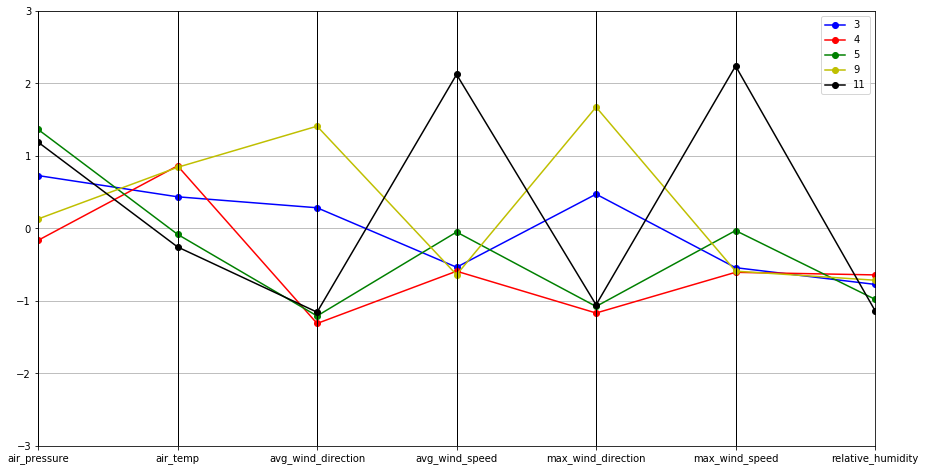

In [110]:
parallel_plot(P[P['relative_humidity'] < -0.5])

# Warm Days

Warm days defined by air temperature > 0.5

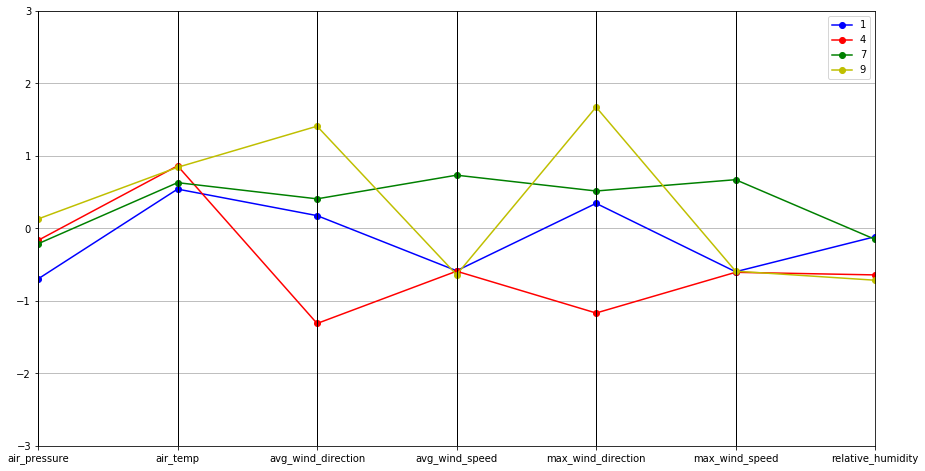

In [99]:
parallel_plot(P[P['air_temp'] > 0.5])

# Cool Days

Cool days specified by relative humidity > 0.5 and air temperature < 0.5

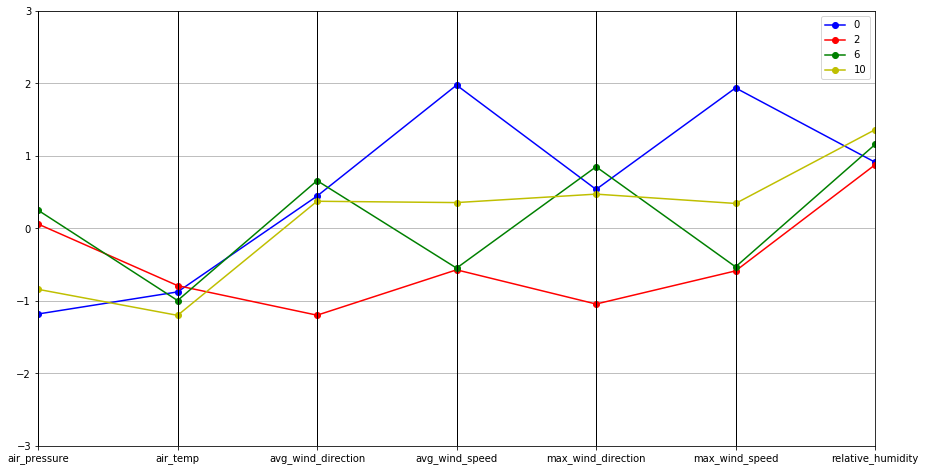

In [102]:
parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)])